# Technical part of MSc project solution
## by Konstantin Orlovskiy
### student ID 13157188

# Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import json

from itertools import islice
from itertools import combinations

from scipy.sparse import coo_matrix  # LightFM fit method requires coo matrix format as input.
from scipy.sparse import csr_matrix

from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k
from lightfm.cross_validation import random_train_test_split
from sklearn.model_selection import train_test_split
from lightfm.data import Dataset

/Users/konstantinorlovskiy/opt/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
# Save start point to calculate the full code run time.

full_cycle_time_start = time.time()

# Data

In [3]:
# Source of data for this project is available via url:
# https://www.kaggle.com/retailrocket/ecommerce-dataset

# Preprocessing
## Data Import and Cleaning - Events

In [4]:
# Importing Events data and sorting by timestamp column which corresponds the historical order of events.

df_events = pd.read_csv("events.csv")
df_events = df_events.sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)

In [5]:
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1430622004384,693516,addtocart,297662,NaN
1,1430622011289,829044,view,60987,NaN
2,1430622013048,652699,view,252860,NaN
3,1430622024154,1125936,view,33661,NaN
4,1430622026228,693516,view,297662,NaN


In [6]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
timestamp        int64
visitorid        int64
event            object
itemid           int64
transactionid    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [7]:
# Save original dataframe count of users, items, interactions.
# Calculate the sparsity of original dataframe.

qty_all_users_original = len(df_events.visitorid.unique())
qty_all_items_original = len(df_events.itemid.unique())
qty_all_interactions_original = len(df_events)
sparsity_original = 1-qty_all_interactions_original/(qty_all_users_original*qty_all_items_original)

print('Original number of users:', qty_all_users_original)
print('Original number of items:', qty_all_items_original)
print('Original number of interactions:', qty_all_interactions_original)
print('Original sparsity:', round(sparsity_original*100,6), '%')

Original number of users: 1407580
Original number of items: 235061
Original number of interactions: 2756101
Original sparsity: 99.999167 %


In [8]:
# Events types “view”, “addtocart”, “transaction” cannot be considered as rating (explicit feedback).
# This information is implicit feedback and lightFM library was designed to deal with it.
# Transform events from categorical to numerical format for further processing.

weight_view = 1
weight_addtocart = 2
weight_transaction = 3

df_events.event.replace(to_replace=dict(
    view=weight_view, addtocart=weight_addtocart, transaction=weight_transaction), inplace=True)

In [9]:
# Now the events replaced with corresponding weights.
df_events.event.unique()

array([2, 1, 3])

In [10]:
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1430622004384,693516,2,297662,NaN
1,1430622011289,829044,1,60987,NaN
2,1430622013048,652699,1,252860,NaN
3,1430622024154,1125936,1,33661,NaN
4,1430622026228,693516,1,297662,NaN


In [11]:
# The user may have interacted with item multiple times which is now stored in dataframe.
# For current purpose of recommendation we're interested in the highest level of user interest to the item.
# Therefore, the data can be further cleaned.

df_events = df_events.sort_values('event').drop_duplicates(
    subset=['visitorid', 'itemid'], 
    keep='last').sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)

In [12]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2145179 entries, 0 to 2145178
Data columns (total 5 columns):
timestamp        int64
visitorid        int64
event            int64
itemid           int64
transactionid    float64
dtypes: float64(1), int64(4)
memory usage: 81.8 MB


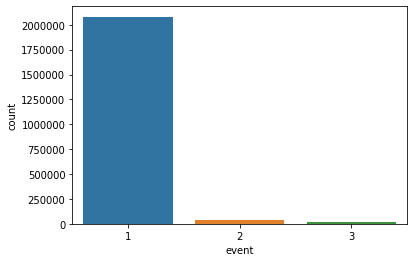

In [13]:
# View on the ratio between different types of events.
sns.countplot(x='event', data=df_events)

In [14]:
# Count activities by user.
users_activity = df_events.groupby('visitorid').visitorid.count().to_frame(name='activity_count')
users_activity.head()

,activity_count
visitorid,
0,3
1,1
2,4
3,1
4,1


In [15]:
# View on the most active users
users_activity.loc[users_activity['activity_count'] > 1000].sort_values(
    by='activity_count', ascending=False).head(10)

,activity_count
visitorid,
1150086,3814
530559,2209
892013,1738
895999,1641
152963,1622
371606,1399
163561,1314
79627,1257
286616,1230


In [16]:
# View on historical behaviour of one user 1150086.

df_events.loc[df_events['visitorid'] == 1150086].head(10)

,timestamp,visitorid,event,itemid,transactionid
628771,1434034517389,1150086,1,133542,NaN
629008,1434035735608,1150086,1,167873,NaN
629054,1434036006651,1150086,1,231726,NaN
629104,1434036288806,1150086,1,427777,NaN
629170,1434036525614,1150086,3,398115,7510.0
629208,1434036727711,1150086,1,203425,NaN
629246,1434036891672,1150086,1,458489,NaN
629369,1434037348016,1150086,3,375955,6495.0
629421,1434037596453,1150086,3,357133,5235.0
629625,1434038553908,1150086,2,368244,NaN


In [17]:
# Check the hypothesys: the more interactions the user had, the more likely addtocart/purchase was made.
# Based on this hypothesys the users can be divided into two groups.

# First group is 'low activity' users - this group is mostly browsing and not making many purchases.
# The ratio of addtocart/purchase is low so it is harder to understand what they really like.
# These users will create a noise for the pool of more active users having higher conversion.
# All types of interactions (view/addtocart/purchase) can be counted as positive for 'low activity' users.
# This will lead at least to improvement of customer experience and users are more likely to find the needed item.
# For the purposes of this project 'low activity' group will be left aside as the goal is basket value, not UX.
# This will allow to get rid of noise.

# Second group is 'high activity' users - this group has higher ratio of purchases.
# Addtocart interaction type is considered to be positive as purchase.
# The item can be added to cart and purchased later, or customer purchased similar item somewhere else.
# All in all, the fact of adding to cart means high interest to the item.
# Ratio of addtocart and purchase to view is relatively similar which proves this assumption.
# So, interactions types addtocart/purchase can be considered as positive, and predictions be made on them.
# View interactions are not considered since the user has not proceeded so this means there's low interest.
# For the purposes of this project 'high activity' group will be used.

# To summarize, using this split resolves several issues:
# 1. The low activity users represent the noise which will affect the model performance. So they are not considered.
# 2. The size of dataframe used for the further steps will be significantly smaller saving computational cost.

In [18]:
# Develop the function to see how the number of interactions impacts conversion.
# Conversion is a ratio of positive interactions(cart, purchase) to total number of interactions.

def activity_counter(data, max_interaction_threshold):
    
    df_events = data
    users_activity = df_events.groupby('visitorid').visitorid.count().to_frame(name='activity_count')
    count_aggregated = pd.DataFrame(columns = ['interaction_threshold', 
                                               'view', 'addtocart', 'purchase', 
                                               'conversion', 
                                               'total_interactions'])
    
    for interaction_threshold in range(max_interaction_threshold):
        users_activity_low = users_activity.loc[users_activity['activity_count'] <= interaction_threshold]
        users_to_remove = users_activity_low.index.tolist()
        df_events = df_events[~df_events.visitorid.isin(users_to_remove)].reset_index(drop=True)
        
        count = df_events['event'].value_counts()
        count_aggregated = count_aggregated.append({
            'interaction_threshold': int(interaction_threshold), 
            'view': int(count[weight_view]), 
            'addtocart': int(count[weight_addtocart]), 
            'purchase': int(count[weight_transaction]), 
            'conversion': (count[weight_addtocart] + count[weight_transaction])/len(df_events),
            'total_interactions': len(df_events)
        }, 
            ignore_index=True)
        
    return(count_aggregated)

In [19]:
# Run fuction.
activities = activity_counter(df_events, 100)
activities.head(10)

,interaction_threshold,view,addtocart,purchase,conversion,total_interactions
0,0.0,2080929.0,42980.0,21270.0,0.029951,2145179.0
1,1.0,978187.0,30775.0,16717.0,0.046303,1025679.0
2,2.0,645875.0,24367.0,14335.0,0.056534,684577.0
3,3.0,488582.0,20490.0,12800.0,0.063790,521872.0
4,4.0,397669.0,17758.0,11809.0,0.069205,427236.0
5,5.0,337186.0,15840.0,10960.0,0.073629,363986.0
6,6.0,294957.0,14365.0,10264.0,0.077065,319586.0
7,7.0,264109.0,13083.0,9809.0,0.079763,287001.0
8,8.0,239898.0,12078.0,9441.0,0.082317,261417.0
9,9.0,220596.0,11162.0,9085.0,0.084067,240843.0


Text(0.5, 0, 'Interactions per user')

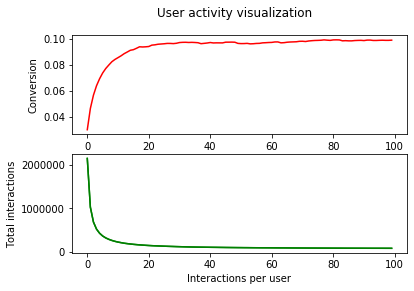

In [20]:
figure, (axis_1, axis_2) = plt.subplots(2)
figure.suptitle('User activity visualization')

axis_1.plot(activities['interaction_threshold'], activities['conversion'], 'r')
axis_1.set_ylabel('Conversion')

axis_2.plot(activities['interaction_threshold'], activities['total_interactions'], 'g')
axis_2.plot(activities['interaction_threshold'], activities['total_interactions'], 'g')
axis_2.set_ylabel('Total interactions')
axis_2.set_xlabel('Interactions per user')

In [21]:
# The plot above shows that positive ratio improvement slows down significantly at 20 interactions threshold.
# Plateau is at conversion rate ~0.1 (10%) which is good in comparison to eCommerce industry standard 3%.
# It makes sense since the part of less active users was removed.

# Hypothesis is now proved. 

# Split point to divide users into two groups:
# 'low activity' users with 20 and less interactions.
# 'high activity' users with more than 20 interactions.

In [22]:
# Set interactions threshold and remove 'low activity' users.

interaction_threshold = 20

# Create list of users that need to be removed from events data.
users_activity_low = users_activity.loc[users_activity['activity_count'] <= interaction_threshold]
users_to_remove = users_activity_low.index.tolist()

# Remove low activity users from dataframe.
df_events = df_events[~df_events.visitorid.isin(users_to_remove)].reset_index(drop=True)

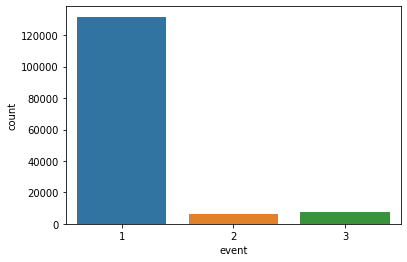

In [23]:
# View on the ratio between different types of events after cleaning.
sns.countplot(x='event', data=df_events)

In [24]:
# Select which types of interaction to be used: weight_view / weight_addtocart / weight_transaction.
# View interactions are not considered since the user has not proceeded so this means there's low interest.

df_events = df_events.loc[df_events['event'].isin(
    [weight_addtocart, 
     weight_transaction])].reset_index(drop=True)

df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13675 entries, 0 to 13674
Data columns (total 5 columns):
timestamp        13675 non-null int64
visitorid        13675 non-null int64
event            13675 non-null int64
itemid           13675 non-null int64
transactionid    7271 non-null float64
dtypes: float64(1), int64(4)
memory usage: 534.3 KB


In [25]:
# Final view on users and items participating in model training and testing. 

qty_all_users = len(df_events['visitorid'].unique())
print('Original number of users:', qty_all_users_original)
print('Cleaned dataset number of users: ', qty_all_users)
print('Cleaned portion:', round(100*qty_all_users/qty_all_users_original,2), '%')
print()

qty_all_items = len(df_events['itemid'].unique())
print('Original number of items:', qty_all_items_original)
print('Cleaned dataset number of items: ', qty_all_items)
print('Cleaned portion:', round(100*qty_all_items/qty_all_items_original,2), '%')
print()

qty_all_interactions = len(df_events)
print('Original number of interactions:', qty_all_interactions_original)
print('Cleaned dataset number of interactions: ', qty_all_interactions)
print('Cleaned portion:', round(100*qty_all_interactions/qty_all_interactions_original,2), '%')
print()

sparsity = 1-qty_all_interactions/(qty_all_users*qty_all_items)
print('Original sparsity: ', round(sparsity_original*100,6), '%')
print('Cleaned sparsity: ', round(100*sparsity,6), '%')

Original number of users: 1407580
Cleaned dataset number of users:  1015
Cleaned portion: 0.07 %

Original number of items: 235061
Cleaned dataset number of items:  9490
Cleaned portion: 4.04 %

Original number of interactions: 2756101
Cleaned dataset number of interactions:  13675
Cleaned portion: 0.5 %

Original sparsity:  99.999167 %
Cleaned sparsity:  99.85803 %


### Train / Test split

In [26]:
# Interactions data may depend on seasonality and specific eCommerce events.
# In order to achieve the generalization, the train and test split will be done randomly.

df_events_train, df_events_test = train_test_split(df_events, 
                                                   test_size=0.2, 
                                                   random_state=np.random.RandomState(2020))

In [27]:
# The dataset used for this project does not have any user information (features) available.
# Therefore, on the evaluation phase there should be only those users, that used to train the model.
# Otherwise the user cold start problem will be faced which will impact the evaluation results.
# Meanwhile, this is not the case for items since there's the item features data available.

df_events_test = df_events_test[(df_events_test['visitorid'].isin(df_events_train['visitorid'])) & 
                                (df_events_test['itemid'].isin(df_events_train['itemid']))]

In [28]:
df_events_train.head()

,timestamp,visitorid,event,itemid,transactionid
5051,1434737258535,76757,2,338427,NaN
10544,1439321239415,152963,3,55955,180.0
8837,1437780903046,861299,3,131034,7162.0
8628,1437674156662,883745,3,352742,11316.0
11268,1440017757081,303381,3,162046,13787.0


In [29]:
df_events_test.head()

,timestamp,visitorid,event,itemid,transactionid
10711,1439484590277,1150086,3,253615,9457.0
1906,1432165517784,138131,3,176995,6308.0
5733,1435276573581,706387,2,283492,NaN
10068,1438827382136,478537,2,207430,NaN
7711,1436984362651,152693,2,64026,NaN


In [30]:
print('Test set represents', round(100*len(df_events_test)/len(df_events_train),2),'% of Train set.')
print('Total number of interactions participating in train:',len(df_events_train),'/ test: ', len(df_events_test))

Test set represents 10.39 % of Train set.
Total number of interactions participating in train: 10940 / test:  1137


### Transforming interactions data into the format acceptable by lightFM model

In [31]:
# Dataset class of LightFM package has method build_interactions that allows to fill in the interactions matrix.
# As the input for this method need to pass the list of tuples (visitorid, itemid, weight).

start_time = time.time()

# Train set interactions transformed.
df_events_train_interactions = []
for index, row in df_events_train.iterrows():
    df_events_train_interactions.append((int(row['visitorid']), int(row['itemid']), int(row['event'])))
    
# Test set interactions transformed.
df_events_test_interactions = []
for index, row in df_events_test.iterrows():
    df_events_test_interactions.append((int(row['visitorid']), int(row['itemid']), int(row['event'])))
    
# Full set of interactions transformed. This will be used for production recommendations.
df_events_all_interactions = []
for index, row in df_events.iterrows():
    df_events_all_interactions.append((int(row['visitorid']), int(row['itemid']), int(row['event'])))
    
print('Finished in: ', round((time.time()-start_time)/60, 2), " minutes")

Finished in:  0.02  minutes


In [32]:
# Check original VS transformed length, should be equal.

print('Check original VS transformed length TRAIN: ', 
     len(df_events_train),
     '/',
     len(df_events_train_interactions))

print('Check original VS transformed length TEST: ', 
     len(df_events_test),
     '/',
     len(df_events_test_interactions))

print('Check original VS transformed length ALL: ', 
     len(df_events),
     '/',
     len(df_events_all_interactions))

Check original VS transformed length TRAIN:  10940 / 10940
Check original VS transformed length TEST:  1137 / 1137
Check original VS transformed length ALL:  13675 / 13675


In [33]:
# Cross check successful.

# Preprocessing
## Data Import and Cleaning - Item Properties

In [34]:
# Import Properties

df_properties1 = pd.DataFrame(pd.read_csv("item_properties_part1.csv"))
df_properties2 = pd.DataFrame(pd.read_csv("item_properties_part2.csv"))
df_properties = pd.concat([df_properties1, df_properties2])

# data to be sorted by timestamp to reflect the historical change log.
df_properties = df_properties.sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)

df_properties.head(10)

,timestamp,itemid,property,value
0,1431226800000,317951,790,n32880.000
1,1431226800000,422842,480,1133979
2,1431226800000,310185,776,103591
3,1431226800000,110973,112,679677
4,1431226800000,179597,available,0
5,1431226800000,260136,available,1
6,1431226800000,138592,764,1285872
7,1431226800000,216269,364,336749
8,1431226800000,299944,764,1285872
9,1431226800000,146103,112,679677


In [35]:
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
timestamp    int64
itemid       int64
property     object
value        object
dtypes: int64(2), object(2)
memory usage: 618.8+ MB


In [36]:
# Store the original size of item features dataframe.

df_properties_len_orig = len(df_properties)

In [37]:
# All the categories names and values are hashed excepting "categoryid" and "available".

df_properties.loc[df_properties['itemid'] == 216269].head()

,timestamp,itemid,property,value
7,1431226800000,216269,364,336749
517912,1431226800000,216269,categoryid,1029
820516,1431226800000,216269,917,378110 n18720.000
873983,1431226800000,216269,available,0
928887,1431226800000,216269,790,n51900.000


In [38]:
# The model is unable to process the historical log so there's a need to trim the properties data.
# The latest properties data is considered to be the best to describe items.
# Assumption: the ecommerce team was constantly improving the catalogue.
# This action should lead to decrease of the dataframe size.

df_properties = df_properties.sort_values(by=['timestamp'], ascending=True).drop_duplicates(
    subset=['itemid', 'property'], 
    keep='last').reset_index(drop=True)

df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12003814 entries, 0 to 12003813
Data columns (total 4 columns):
timestamp    int64
itemid       int64
property     object
value        object
dtypes: int64(2), object(2)
memory usage: 366.3+ MB


In [39]:
# Additionally, we can get rid of the 'available' property completely.
# It won't make sense to consider any value as fixed (in stock or not in stock) for trainig purposes.
# In production this property can be used in real time to filter out unavailable items from prediction.

df_properties = df_properties[~df_properties.property.isin(['available'])].reset_index(drop=True)

df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11586761 entries, 0 to 11586760
Data columns (total 4 columns):
timestamp    int64
itemid       int64
property     object
value        object
dtypes: int64(2), object(2)
memory usage: 353.6+ MB


In [40]:
# As the next step the items which are not present in the cleaned dataframe can also be removed.

df_properties = df_properties[df_properties.itemid.isin(df_events['itemid'])].reset_index(drop=True)

df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255722 entries, 0 to 255721
Data columns (total 4 columns):
timestamp    255722 non-null int64
itemid       255722 non-null int64
property     255722 non-null object
value        255722 non-null object
dtypes: int64(2), object(2)
memory usage: 7.8+ MB


In [41]:
# Timestamp column can also be removed as it is redundant.

df_properties = df_properties.drop(['timestamp'], axis=1)

In [42]:
# Sort dataframe by itemid.

df_properties = df_properties.sort_values(by=['itemid'], ascending=True).reset_index(drop=True)

In [43]:
print('Cleaned properties dataframe represents ',
      round(100*len(df_properties)/df_properties_len_orig,2),
     ' % of original dataframe.')

Cleaned properties dataframe represents  1.26  % of original dataframe.


In [44]:
qty_all_properties = len(df_properties['property'].unique())
print('Cleaned dataset number of properties: ', qty_all_properties)
print('Cleaned dataset number of properties values: ', len(df_properties))
print()
print('Cleaned dataset number of items: ', qty_all_items)
print('Cleaned dataset number of users: ', qty_all_users)
print('Cleaned dataset number of interactions: ', len(df_events))

Cleaned dataset number of properties:  907
Cleaned dataset number of properties values:  255722

Cleaned dataset number of items:  9490
Cleaned dataset number of users:  1015
Cleaned dataset number of interactions:  13675


In [45]:
df_properties.head(10)

,itemid,property,value
0,15,678,245772
1,15,915,769062
2,15,112,679677
3,15,812,769062
4,15,764,1285872
5,15,839,245772
6,15,616,769062
7,15,888,789221
8,15,776,604754
9,15,917,789221


### Transforming item features data into the format acceptable by lightFM model.

In [46]:
# The item features information should be passed to the lightFM model in a format of csr matrix.
# This matrix must have mapping of all items related to the train/test process and 
# all features available in cleaned properties dataframe.
# Then the matrix is to be filled in with the properties values.
# LightFM model would be then capable to create a latent features vector for each item.


In [47]:
df_properties.loc[df_properties['itemid'] == 15].head()

,itemid,property,value
0,15,678,245772
1,15,915,769062
2,15,112,679677
3,15,812,769062
4,15,764,1285872


In [48]:
# Dataset class has the method build_item_features that allows to fill in the properties data using created mapping.
# Add feature mapping to the existing dataset using fit_partial method.
# Data needs to be transformed to the acceptable format.
# https://github.com/lyst/lightfm/issues/393#issuecomment-438237971


# Transform item features list to the format required by Dataset class:
# ['property:value']

item_features_mapping = []
for index, row in df_properties.iterrows():
    item_features_mapping.append(str(row['property']) + ':' + str(row['value']))
    
print('Properties mapping has:', len(item_features_mapping), 'records')

Properties mapping has: 255722 records


In [49]:
# As the next step need to remove duplicates in this list.
# So basically the feature mapping length is not equal to the number of features, 
# but is equal to the number of combinations ['property:value'] available in the dataframe.
# There's no need to "create" all possible combinations mapping as this is redundant info.
# Just need to create mapping for existing combinations.
# Additionally, the LightFM package allows to add weight to this combination if needed.

item_features_mapping = list( dict.fromkeys(item_features_mapping) )
print('Properties mapping has:', len(item_features_mapping), 'unique records')

Properties mapping has: 71436 unique records


In [50]:
# Transform item features values to the format required by Dataset class:
# [ (itemid_1, ['property_1:value_1', 'property_2:value_2']) ]

start_time = time.time()

item_features_values = []
current_item = df_properties.itemid[0]
current_item_features = []
for index, row in df_properties.iterrows():
    if row['itemid'] == current_item:
        current_item_features.append(str(row['property']) + ':' + str(row['value']))
    else:
        item_features_values.append((current_item, current_item_features))
        current_item = row['itemid']
        current_item_features = [str(row['property']) + ':' + str(row['value'])]
item_features_values.append((current_item, current_item_features))

print('Finished in: ', round((time.time()-start_time)/60, 2), " minutes")

Finished in:  0.37  minutes


In [51]:
item_features_values[0]

(15,
 ['678:245772',
  '915:769062',
  '112:679677',
  '812:769062',
  '764:1285872',
  '839:245772',
  '616:769062',
  '888:789221',
  '776:604754',
  '917:789221',
  '159:519769',
  '364:1047026',
  '698:433564',
  '283:433564 245772 789221 809278 245772 1213953 429140 1322984 792235 79212 237874 654986 809278 1215254 249416 646928 750061 961877 1152409 780700 1128577 269926 754848 703408 469750 581854 1028919 1124417 484436 1256252 790607',
  'categoryid:722',
  '790:n8400.000',
  '202:789221',
  '227:433564',
  '591:1116693',
  '693:769062'])

# Preprocessing

## Create LightFM dataset mapping

In [52]:
# For model evaluation purposes (auc_score) dimensionality of train/test interaction matrices should be the same.
# In order to achieve this, need to create mapping for all users and all items.
# Then separately for train and test - the interactions will be filled in.

In [53]:
# Create mapping for users, items and item features.

# The fit method of class Dataset takes the list of all the visitors and items.
# The implementation allows to ignore duplicates.

# Train set mapping.
dataset = Dataset()
dataset.fit(
    users = (x for x in df_events['visitorid']),
    items = (x for x in df_events['itemid']), 
    user_features=None, 
    item_features=item_features_mapping
)

dataset_train = dataset
dataset_test = dataset
dataset_all = dataset  # This will be used for production recommendations.

## Populate LightFM dataset with data

In [54]:
# Populate interactions matrix for train and test sets.

start_time = time.time()

(interactions_train, weights_train) = dataset_train.build_interactions(df_events_train_interactions)
(interactions_test, weights_test) = dataset_test.build_interactions(df_events_test_interactions)
(interactions_all, weights_all) = dataset_all.build_interactions(df_events_all_interactions)


# Choose interactions to be used at next stages.
# The use of weights did not lead to improvement of model performance even after changing the scale to 1/700/1000.
# Reason for that is that the LightFM model does not count in any explicit feedback which the weights can represent.
# The idea behind the implementation is to count in the implicit feedback as binary problem, with either
# positive or negative interactions. As decided above, addtocart and purchase are considered as positive.
# The weights table wil not be needed for the purpose of this project.

train = interactions_train
test = interactions_test
production = interactions_all  # This will be used for production recommendations.

print('Finished in: ', round((time.time()-start_time)/60, 2), " minutes")

Finished in:  0.0  minutes


In [55]:
# Populate item features matrix with values.

start_time = time.time()

item_features = dataset.build_item_features(item_features_values)

print('Finished in: ', round((time.time()-start_time)/60, 2), " minutes")

Finished in:  0.01  minutes


In [56]:
print('Dataset class cross-check.')
print()

num_users, num_items = dataset.interactions_shape()
print('All users expected:', qty_all_users)
print('Actual number of users:', num_users)
print()
print('All items expected:', qty_all_items)
print('Actual number of items:', num_items)
print()

print('Item features matrix is expected to be of size: (', qty_all_items, ',', 
      qty_all_items+len(item_features_mapping), ')')
# Reason for this size is that there's a space for latent vector representation of each item plus all features.
print('Actual size is:', dataset.item_features_shape())
print()

print('Item features matrix number of values is expected to be:', len(df_properties)+qty_all_items)
# Reason for this size is that there's a space for latent vector representation of each item plus all features.
print('Actual number of values is:', item_features.getnnz())
print()

print('Interactions matrix is expected to be of the size: (', qty_all_users, ',', qty_all_items, ')')
print('Actual size is:', dataset.interactions_shape())
print()

print('Interactions matrix number of values is expected to be:', len(df_events_train) + len(df_events_test))
print('Actual number of values is:', train.getnnz() + test.getnnz())
print()

Dataset class cross-check.

All users expected: 1015
Actual number of users: 1015

All items expected: 9490
Actual number of items: 9490

Item features matrix is expected to be of size: ( 9490 , 80926 )
Actual size is: (9490, 80926)

Item features matrix number of values is expected to be: 265212
Actual number of values is: 265212

Interactions matrix is expected to be of the size: ( 1015 , 9490 )
Actual size is: (1015, 9490)

Interactions matrix number of values is expected to be: 12077
Actual number of values is: 12077



# Collaborative LightFM model training

In [57]:
# Item features are not passed to the model. This means pure collaborative filtering.

start_time = time.time()

model_collab = LightFM(no_components=100, loss='warp', random_state=2020)

model_collab.fit(train, 
                 item_features=None, 
                 epochs=100, 
                 num_threads=4)

print('Model trained in: ', round((time.time()-start_time)/60, 2), " minutes")

Model trained in:  0.03  minutes


In [58]:
model_collab.get_params()

{'loss': 'warp',
 'learning_schedule': 'adagrad',
 'no_components': 100,
 'learning_rate': 0.05,
 'k': 5,
 'n': 10,
 'rho': 0.95,
 'epsilon': 1e-06,
 'max_sampled': 10,
 'item_alpha': 0.0,
 'user_alpha': 0.0,
 'random_state': RandomState(MT19937) at 0x7FA2F1DB6160}

# Collaborative LightFM model evaluation

In [59]:
# Since the recommendation engine is a ranking problem, AUC and Precision at K will be used for evaluation.
# Both of them are measuring the ranking quality, which means for each particular user the items can be sorted 
# in the order of their fit/interest to the user.


# [source: https://making.lyst.com/lightfm/docs/lightfm.evaluation.html]

# AUC (area under the curve) shows how well the items are ranked. Perfect ranking means that any random positive
# example will be ranked higher than any random negative example. Highest metric's value is 1.0 (100%)

# Precision at 'k' shows the ratio of known positive examples in top 'k' ranked items.
# Highest metric's value is 1.0 (100%)



# Set parameter "k" value to check precision at "k".
# Initially select k=3 as it will allow to have 4 possible combinations (bundles) to offer with discount 
# to the user and achieve the goal of increasing the basket value.

# User won't be offered set of 2 for each item as this is simpler task and can be implemented on all pages if there
# is a business need for that. This will lead to better user experience and avoid recommending too much which 
# can cause FOMO (fear of missing out) when the user gets stuck in front of too wide range of choices.


k = 3

In [60]:
start_time = time.time()

train_auc = auc_score(model_collab, 
                      train, 
                      item_features=None, 
                      num_threads=4).mean()

print('Train AUC score: ', train_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train AUC score:  0.9999983
Calculated in:  0.01  minutes


In [61]:
start_time = time.time()

# Train interactions will be also passed to avoid model re-recommending items to users.
test_auc = auc_score(model_collab,
                     test, 
                     item_features=None, 
                     train_interactions = train, 
                     num_threads=4).mean()

print('Test AUC score: ', test_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test AUC score:  0.65434647
Calculated in:  0.0  minutes


In [62]:
start_time = time.time()

train_precision = precision_at_k(model_collab, 
                                 train,
                                 item_features=None, 
                                 num_threads=4, 
                                 k=k).mean()

print('Train precision at k: ', train_precision)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train precision at k:  0.7899966
Calculated in:  0.01  minutes


In [63]:
start_time = time.time()

test_precision = precision_at_k(model_collab, 
                                test, 
                                item_features=None, 
                                train_interactions = train, 
                                num_threads=4, 
                                k=k).mean()

print('Test precision at k: ', test_precision)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test precision at k:  0.012444445
Calculated in:  0.0  minutes


In [64]:
model_collab_results = {}
model_collab_results['AUC train'] = train_auc
model_collab_results['AUC test'] = test_auc
model_collab_results['Precision @3 train'] = train_precision
model_collab_results['Precision @3 test'] = test_precision

In [65]:
model_collab_results

{'AUC train': 0.9999983,
 'AUC test': 0.65434647,
 'Precision @3 train': 0.7899966,
 'Precision @3 test': 0.012444445}

# Hybrid LightFM model training 

In [66]:
# Update the model with item features to drive content based filtering. This will mean hybrid predictions.
# Hybrid model is benefiting from collaborative and content based filtering.

start_time = time.time()

model_hybrid = LightFM(no_components=100, loss='warp', random_state=2020)

NUM_EPOCHS = 100  # Initial number of epochs to be set.

model_hybrid.fit(train, 
                 item_features=item_features, 
                 epochs=NUM_EPOCHS, 
                 num_threads=4)

print('Model trained in: ', round((time.time()-start_time)/60, 2), " minutes")

Model trained in:  0.44  minutes


In [67]:
model_hybrid.get_params()

{'loss': 'warp',
 'learning_schedule': 'adagrad',
 'no_components': 100,
 'learning_rate': 0.05,
 'k': 5,
 'n': 10,
 'rho': 0.95,
 'epsilon': 1e-06,
 'max_sampled': 10,
 'item_alpha': 0.0,
 'user_alpha': 0.0,
 'random_state': RandomState(MT19937) at 0x7FA2F1DB65A0}

# Hybrid LightFM model evaluation

In [68]:
start_time = time.time()

train_auc = auc_score(model_hybrid, 
                      train, 
                      item_features=item_features, 
                      num_threads=4).mean()

print('Train AUC score: ', train_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train AUC score:  0.99953717
Calculated in:  0.12  minutes


In [69]:
start_time = time.time()

# Train interactions will be also passed to avoid model re-recommending items to users.
test_auc = auc_score(model_hybrid,
                     test, 
                     item_features=item_features, 
                     train_interactions = train, 
                     num_threads=4).mean()

print('Test AUC score: ', test_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test AUC score:  0.84518975
Calculated in:  0.05  minutes


In [70]:
start_time = time.time()

train_precision = precision_at_k(model_hybrid, 
                                 train,
                                 item_features=item_features, 
                                 num_threads=4, 
                                 k=k).mean()

print('Train precision at k: ', train_precision)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train precision at k:  0.5577252
Calculated in:  0.12  minutes


In [71]:
start_time = time.time()

test_precision = precision_at_k(model_hybrid, 
                                test, 
                                item_features=item_features, 
                                train_interactions = train, 
                                num_threads=4, 
                                k=k).mean()

print('Test precision at k: ', test_precision)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test precision at k:  0.030222224
Calculated in:  0.05  minutes


In [72]:
model_hybrid_results = {}
model_hybrid_results['AUC train'] = train_auc
model_hybrid_results['AUC test'] = test_auc
model_hybrid_results['Precision @3 train'] = train_precision
model_hybrid_results['Precision @3 test'] = test_precision

In [73]:
# Compare results of collaborative and hybrid models
print('Collaborative filtering results: ', model_collab_results)
print()
print('Hybrid filtering results: ', model_hybrid_results)

Collaborative filtering results:  {'AUC train': 0.9999983, 'AUC test': 0.65434647, 'Precision @3 train': 0.7899966, 'Precision @3 test': 0.012444445}

Hybrid filtering results:  {'AUC train': 0.99953717, 'AUC test': 0.84518975, 'Precision @3 train': 0.5577252, 'Precision @3 test': 0.030222224}


In [74]:
# From the above comparison it's clear that passing item features to the model improves both metrics.

# Visualize learning process

In [75]:
# Visualization of the learning process will show how quickly the model as learning during epochs.
# Identifying the point of slowing down or termination of learning will help to improve efficiency by 
# limiting the number of epochs needed to achieve the result that sufficies.

In [76]:
# AUC visualization function.

def learning_vis_auc(model, train, test, item_features, epochs):
    
    stats = pd.DataFrame(columns = ['epochs', 'train_auc', 'test_auc', 'runtime_min'])
    
    total_runtime_min = 0
    
    for epoch in range(1,epochs+1):
        
        start_time = time.time()
        
        model.fit(train, 
                  item_features=item_features, 
                  epochs=epoch, 
                  num_threads=4)
        
        train_auc = auc_score(model, 
                              train, 
                              item_features=item_features, 
                              num_threads=4).mean()

        test_auc = auc_score(model,
                             test, 
                             item_features=item_features, 
                             train_interactions = train, 
                             num_threads=4).mean()

        runtime_min = round((time.time()-start_time)/60, 6)        
        total_runtime_min += runtime_min
        
        stats = stats.append({
            'epochs': int(epoch), 
            'train_auc': float(train_auc), 
            'test_auc': float(test_auc),
            'runtime_min': float(runtime_min)},
            ignore_index=True)
        
    
    import matplotlib.pyplot as plt
    figure, axis = plt.subplots()
    figure.suptitle('Learning progress: AUC')
    axis.plot(stats['epochs'], stats['train_auc'], label='train')
    axis.plot(stats['epochs'], stats['test_auc'], label='test')
    axis.set_xlabel('Epochs')
    axis.set_ylabel('AUC score')
    axis.legend()
    
    return(figure, stats, total_runtime_min)

Calculated in:  42.84  minutes


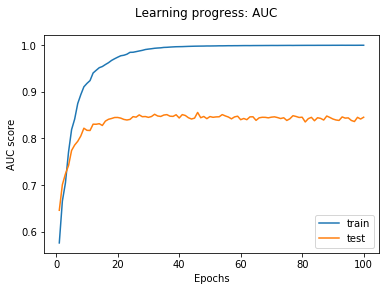

In [77]:
start_time = time.time()

learning_vis_auc_output = learning_vis_auc(model_hybrid, train, test, item_features, epochs=NUM_EPOCHS)

print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

In [78]:
learning_vis_auc_output[1]

,epochs,train_auc,test_auc,runtime_min
0,1.0,0.575920,0.645920,0.193750
1,2.0,0.665595,0.700700,0.202326
2,3.0,0.704638,0.723904,0.211005
3,4.0,0.770477,0.741530,0.218210
4,5.0,0.818777,0.774045,0.228176
...,...,...,...,...
95,96.0,0.999500,0.838356,0.571935
96,97.0,0.999470,0.836078,0.575037
97,98.0,0.999505,0.845081,0.575051
98,99.0,0.999561,0.841411,0.581202


In [79]:
learning_vis_auc_output[2]

42.836369000000005

In [80]:
# Precision visualization.

def learning_vis_precision(model, train, test, item_features, k, epochs):
    
    stats = pd.DataFrame(columns = ['epochs', 'train_precision', 'test_precision', '@k' 'runtime_min'])
    
    total_runtime_min = 0
    
    for epoch in range(1,epochs+1):
        
        start_time = time.time()
        
        model.fit(train, 
                  item_features=item_features,
                  epochs=epoch, 
                  num_threads=4)
        
        train_precision = precision_at_k(model,
                                         train,
                                         item_features=item_features,
                                         num_threads=4, 
                                         k=k).mean()

        test_precision = precision_at_k(model, 
                                        test,
                                        item_features=item_features,
                                        train_interactions=train,
                                        num_threads=4, 
                                        k=k).mean()

        runtime_min = round((time.time()-start_time)/60, 6)
        total_runtime_min += runtime_min
        
        stats = stats.append({
            'epochs': int(epoch), 
            'train_precision': float(train_precision), 
            'test_precision': float(test_precision),
            '@k': int(k), 
            'runtime_min': float(runtime_min)},
            ignore_index=True)
        
    
    import matplotlib.pyplot as plt
    figure, axis = plt.subplots()
    figure.suptitle('Learning progress: precision @%s' %k)
    axis.plot(stats['epochs'], stats['train_precision'], label='train')
    axis.plot(stats['epochs'], stats['test_precision'], label='test')
    axis.set_xlabel('Epochs')
    axis.set_ylabel('Precision')
    axis.legend()
    
    return(figure, stats, total_runtime_min)

Calculated in:  42.6  minutes


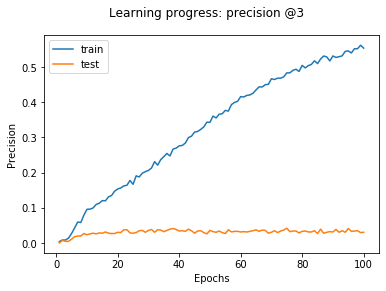

In [81]:
start_time = time.time()

prec_at_3 = learning_vis_precision(model_hybrid, train, test, item_features, k=3, epochs=NUM_EPOCHS)

print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

In [82]:
prec_at_3[1]

,epochs,train_precision,test_precision,@kruntime_min,@k,runtime_min
0,1.0,0.003768,0.000000,NaN,3.0,0.188984
1,2.0,0.008222,0.007111,NaN,3.0,0.195940
2,3.0,0.008222,0.004444,NaN,3.0,0.201109
3,4.0,0.013703,0.004444,NaN,3.0,0.208089
4,5.0,0.026721,0.010667,NaN,3.0,0.215104
...,...,...,...,...,...,...
95,96.0,0.539568,0.032889,NaN,3.0,0.574232
96,97.0,0.551559,0.033778,NaN,3.0,0.574788
97,98.0,0.551559,0.034667,NaN,3.0,0.574860
98,99.0,0.561494,0.029333,NaN,3.0,0.579589


In [83]:
prec_at_3[2]

42.59934299999999

In [84]:
# Conclusion on learning process visualization.

# From the plots above it is clear the learning process slows down significantly after 30 epochs.
# In order to save the computational costs and optimize the process, set new value for NUM_EPOCHS:

NUM_EPOCHS = 30

# Hyperparameter tuning

In [85]:
# Attempting to regularize model and achieve better results on test set by hyperparameter tuning.

# The author of the LightFM package Maciej Kula has also developed the algorythm for hyperparameter tuning.
# Original algorythm was posted on GitHub 23 Apr 2018.
# Code is available via url https://gist.github.com/maciejkula/29aaf2db2efee5775a7f14dc387f0c0f

# For the purposes of this project the original code was modified to meet the needs.

# There will be two attempts:
# AUC focused tuning - when the best model will be chosen based on the best AUC result.
# Precision focused - when the measure of success to chose the best model is precision at 'k'

In [86]:
# Split train set into train_train and validate subsets.

(train_train, validate) = random_train_test_split(train, 
                                                  test_percentage=0.2)

In [87]:
# The range of hyperparameters needs to be set up manually.
# Then function will randomly try various combinations to find the best model depending on goal (AUC/precision).


def sample_hyperparameters():
    
    # Choose the hyperparameters to tune and the range of values.

    while True:
        yield {
            'no_components': np.random.randint(10, 100),
            'learning_schedule': np.random.choice(['adagrad', 'adadelta']),
            'loss': np.random.choice(['bpr', 'warp', 'warp-kos']),
            'k': np.random.randint(1, 10),
            'n': np.random.randint(1, 20),
            'learning_rate': np.random.exponential(0.005),
            'item_alpha': np.random.exponential(1e-10),
            'max_sampled': np.random.randint(5, 30),
            'num_epochs': np.random.randint(10, 100)
        }

# AUC focused model - Tuning

In [88]:
# Improving AUC metric.


def random_search_auc(train_train, validate, num_samples=50, num_threads=4):
    
    # Randomly search for various combinations of hyperparameters.


    for hyperparams in islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop('num_epochs')

        model_tuned_auc = LightFM(**hyperparams)
        model_tuned_auc.fit(train_train, epochs=num_epochs, num_threads=num_threads)

        ranking_score = auc_score(model_tuned_auc, 
                                  validate, train_interactions=train_train, 
                                  num_threads=num_threads).mean()

        hyperparams['num_epochs'] = num_epochs
        
        yield (ranking_score, hyperparams, model_tuned_auc)
        # Returns: generator of (auc score, hyperparameter dict, fitted model)





start_time = time.time()

if __name__ == '__main__':
    
    (ranking_score, hyperparams, model_tuned_auc) = max(random_search_auc(train_train, validate), 
                                                        key=lambda x: x[0])

    print('Best ranking score {} at {}'.format(ranking_score, hyperparams))
    print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Best ranking score 0.5364086031913757 at {'no_components': 63, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'k': 8, 'n': 17, 'learning_rate': 0.0032541544211442037, 'item_alpha': 7.961395805169449e-11, 'max_sampled': 25, 'num_epochs': 33}
Calculated in:  1.07  minutes


# AUC focused model - Training

In [89]:
# Use the tuned model.

start_time = time.time()

model_tuned_auc.fit(train,
                    item_features=item_features,
                    epochs=hyperparams['num_epochs'],
                    num_threads=4)

print('Model trained in: ', round((time.time()-start_time)/60, 2), " minutes")

Model trained in:  0.25  minutes


# AUC focused model - Evaluation

In [90]:
start_time = time.time()

train_auc = auc_score(model_tuned_auc, 
                      train, 
                      item_features=item_features, 
                      num_threads=4).mean()

print('Train AUC score: ', train_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train AUC score:  0.9620935
Calculated in:  0.14  minutes


In [91]:
start_time = time.time()

# Train interactions will be also passed to avoid model re-recommending items to users.
test_auc = auc_score(model_tuned_auc,
                     test, 
                     item_features=item_features, 
                     train_interactions = train, 
                     num_threads=4).mean()

print('Test AUC score: ', test_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test AUC score:  0.8172267
Calculated in:  0.06  minutes


In [92]:
# Conclusion:
# Achieved test AUC is lower than original hybrid filtering model result.

print('Hybrid filtering results: ', model_hybrid_results)

Hybrid filtering results:  {'AUC train': 0.99953717, 'AUC test': 0.84518975, 'Precision @3 train': 0.5577252, 'Precision @3 test': 0.030222224}


In [93]:
# Visualize how the precision changes depending on parameter 'k'.
# Since the hyperparameters tuning was not optimized for parameter 'k', the model can be checked at a range of 'k'.

def k_vis_precision(model, train, test, item_features, epochs):
    
    stats = pd.DataFrame(columns = ['@k', 'train_precision', 'test_precision', 'runtime_min'])
    
    model.fit(train,
              item_features=item_features,
              epochs=epochs, 
              num_threads=4)  
    
    total_runtime_min = 0
    
    for k in range(1,51):
        
        start_time = time.time()
        
        
        train_precision = precision_at_k(model, 
                                         train,
                                         item_features=item_features, 
                                         num_threads=4, 
                                         k=k).mean()

        test_precision = precision_at_k(model, 
                                        test,
                                        item_features=item_features, 
                                        train_interactions = train, 
                                        num_threads=4, 
                                        k=k).mean()

        runtime_min = round((time.time()-start_time)/60, 6)
        total_runtime_min += runtime_min
        
        stats = stats.append({
            '@k': int(k), 
            'train_precision': float(train_precision), 
            'test_precision': float(test_precision),
            'runtime_min': float(runtime_min)},
            ignore_index=True)
        
    
    import matplotlib.pyplot as plt
    figure, axis = plt.subplots()
    figure.suptitle('Precision VS k')
    axis.plot(stats['@k'], stats['train_precision'], label='train')
    axis.plot(stats['@k'], stats['test_precision'], label='test')
    axis.set_xlabel('@k')
    axis.set_ylabel('Precision')
    axis.legend()
    
    return(figure, stats, total_runtime_min)

Calculated in:  10.39  minutes


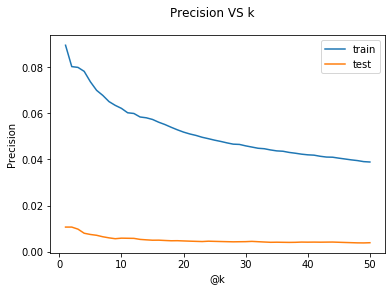

In [94]:
start_time = time.time()

k_vis_precision_output = k_vis_precision(model_tuned_auc, 
                                         train, test, 
                                         item_features, 
                                         epochs=hyperparams['num_epochs'])

print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

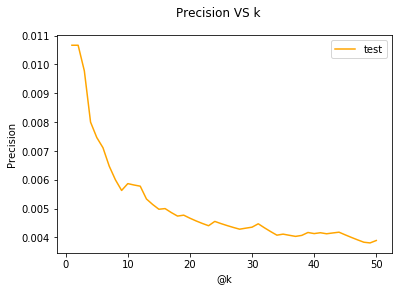

In [95]:
# Plot test precision separately to have a closer look at behaviour.

figure, axis = plt.subplots()
figure.suptitle('Precision VS k')
axis.plot(k_vis_precision_output[1]['@k'], k_vis_precision_output[1]['test_precision'], label='test',color='orange')
axis.set_xlabel('@k')
axis.set_ylabel('Precision')
axis.legend()

In [96]:
k_vis_precision_output[1]

,@k,train_precision,test_precision,runtime_min
0,1.0,0.089414,0.010667,0.199227
1,2.0,0.080164,0.010667,0.202507
2,3.0,0.079822,0.009778,0.202348
3,4.0,0.078109,0.008000,0.201115
4,5.0,0.073587,0.007467,0.201835
5,6.0,0.069887,0.007111,0.202830
6,7.0,0.067685,0.006476,0.201747
7,8.0,0.065005,0.006000,0.202387
8,9.0,0.063378,0.005630,0.202498
9,10.0,0.062076,0.005867,0.198151


In [97]:
k_vis_precision_output[2]

10.136576999999997

In [98]:
# Conclusion:
# The highest test precision is significantly lower than original hybrid filtering model result.

print('Hybrid filtering results: ', model_hybrid_results)

Hybrid filtering results:  {'AUC train': 0.99953717, 'AUC test': 0.84518975, 'Precision @3 train': 0.5577252, 'Precision @3 test': 0.030222224}


In [99]:
# Summary:
# AUC focused hyperparameter tuning did not lead to model performance improvement.

# Precision focused model - Tuning

In [100]:
# Improving precision_at_k metric.

def random_search_precision(train_train, validate, num_samples=10, k=k, num_threads=4):
    
    # Randomly search for various combinations of hyperparameters.


    for hyperparams in islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop('num_epochs')

        model_tuned_precis = LightFM(**hyperparams)
        model_tuned_precis.fit(train_train, epochs=num_epochs, num_threads=num_threads)

        ranking_score = precision_at_k(model_tuned_precis, validate, train_interactions=train_train, 
                                       num_threads=num_threads, 
                                       k=k).mean()

        hyperparams['num_epochs'] = num_epochs
        
        yield (ranking_score, hyperparams, model_tuned_precis)
        # Returns: generator of (precision_at_k, hyperparameter dict, fitted model)





start_time = time.time()

if __name__ == '__main__':
    
    (ranking_score, hyperparams, model_tuned_precis) = max(random_search_precision(train_train, validate), 
                                                           key=lambda x: x[0])

    print('Best presicion ranking score {} at {}'.format(ranking_score, hyperparams))
    print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Best presicion ranking score 0.009803921915590763 at {'no_components': 75, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'k': 5, 'n': 5, 'learning_rate': 0.007417186569917661, 'item_alpha': 5.626895454036104e-13, 'max_sampled': 21, 'num_epochs': 98}
Calculated in:  0.25  minutes


# Precision focused model - Training

In [101]:
# Use the tuned model.

start_time = time.time()

model_tuned_precis.fit(train, 
                       item_features=item_features, 
                       epochs=hyperparams['num_epochs'], 
                       num_threads=4)

print('Model trained in: ', round((time.time()-start_time)/60, 2), " minutes")

Model trained in:  0.61  minutes


In [102]:
# Tuned model evaluation (auc_score, precision_at_k)

In [103]:
start_time = time.time()

train_auc = auc_score(model_tuned_precis, 
                      train, 
                      item_features=item_features, 
                      num_threads=4).mean()

print('Train AUC score: ', train_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train AUC score:  0.95148015
Calculated in:  0.12  minutes


In [104]:
start_time = time.time()

# Train interactions fill be also passed to avoid model re-recommending items to users.
test_auc = auc_score(model_tuned_precis,
                     test, 
                     item_features=item_features, 
                     train_interactions = train, 
                     num_threads=4).mean()

print('Test AUC score: ', test_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test AUC score:  0.83780867
Calculated in:  0.05  minutes


In [105]:
# Conclusion:
# Achieved test AUC is lower than original hybrid filtering model result.

print('Hybrid filtering results: ', model_hybrid_results)

Hybrid filtering results:  {'AUC train': 0.99953717, 'AUC test': 0.84518975, 'Precision @3 train': 0.5577252, 'Precision @3 test': 0.030222224}


Calculated in:  8.8  minutes


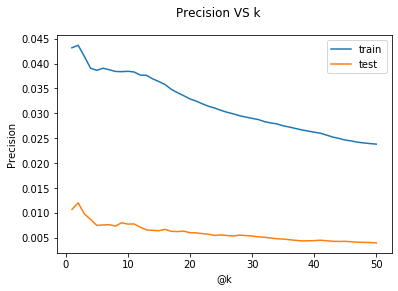

In [106]:
# Visualize how the precision changes depending on parameter 'k'.

start_time = time.time()

k_vis_precision_output = k_vis_precision(model_tuned_precis, 
                                         train, test, item_features, 
                                         epochs=hyperparams['num_epochs'])

print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

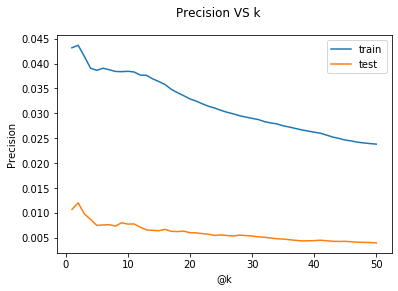

In [107]:
k_vis_precision_output[0]

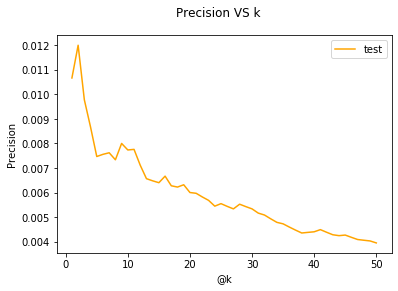

In [108]:
# Plot test precision separately to have a closer look at behaviour.

figure, axis = plt.subplots()
figure.suptitle('Precision VS k')
axis.plot(k_vis_precision_output[1]['@k'], k_vis_precision_output[1]['test_precision'], label='test',color='orange')
axis.set_xlabel('@k')
axis.set_ylabel('Precision')
axis.legend()

In [109]:
k_vis_precision_output[1]

,@k,train_precision,test_precision,runtime_min
0,1.0,0.043165,0.010667,0.167324
1,2.0,0.043679,0.012000,0.158995
2,3.0,0.041453,0.009778,0.167088
3,4.0,0.039054,0.008667,0.167690
4,5.0,0.038643,0.007467,0.165195
5,6.0,0.039054,0.007556,0.165602
6,7.0,0.038761,0.007619,0.167225
7,8.0,0.038412,0.007333,0.169147
8,9.0,0.038369,0.008000,0.167507
9,10.0,0.038438,0.007733,0.166355


In [110]:
# Conclusion:
# Test precision at k=1 (highest) and k=3 is significantly lower than original hybrid filtering model result (k=3).

print('Hybrid filtering results: ', model_hybrid_results)

Hybrid filtering results:  {'AUC train': 0.99953717, 'AUC test': 0.84518975, 'Precision @3 train': 0.5577252, 'Precision @3 test': 0.030222224}


In [111]:
# Summary:
# Precision focused hyperparameter tuning did not lead to model performance improvement.

# Conclusion on the Model

In production the model should can be evaluated on the recommendations conversion rate and basket value. The big difference is that in production the users will be given the recommendations and will possibly interact with them.

Since this project is done in isolated environment, where the test set of users isn't actually getting recommendations, the best possible way to evaluate the model is to see the AUC and precision at k metrics.

Item features were successfully used to improve the model performance.

The best achieved test AUC is ~0.84, which means that in 84% of the cases randomly selected positive interaction is ranked higher than any randomly selected negative interaction. This metrics determines how well the products are ranked for each particular user.

The best achieved test precision is 0.03 at k=3, which means in 3% of the cases the positive interaction is in the top 3 recommended items.

Both achieved AUC and precision are comparable to the available web results.

Hyperparameter tuning has not led to improvement of both metrics.

In [112]:
model_best = model_hybrid

In [113]:
full_cycle_time_end = time.time()

    
print('Full code has been run in: ', 
      round((full_cycle_time_end-full_cycle_time_start)/60, 2), 
      ' minutes')

Full code has been run in:  109.71  minutes


# Recommendations

### Develop recommender function returning the list of top items for each user, no bundles.

In [114]:
# Recommedations algorythm was developed by the author of LightFM package, it is modified for current project.
# https://making.lyst.com/lightfm/docs/quickstart.html

def recommend(model_trained, dataset, interactions, userids, N):
    
    '''
    model_trained - the trained model to be used for recommendations.
    dataset - LightFM Dataset class used to create mapping.
    interactions - coo matrix of known positive interactions.
    users - list of users for recommendations.
    N - top N recommendations to return.
    '''

    model = model_trained
    # Extract user and item mapping from created Dataset class.
    # Mapping is stored as tuple of arrays (user id map, user feature map, item id map, item feature map).
    # Need to extract arrays with  index 0 and 2.
    mapping_users = dataset.mapping()[0]
    mapping_items = dataset.mapping()[2]
    
    output = {}
    
    for user in userids:
        
        # Convert user to internal index.
        user_internal = mapping_users[user]
        
        # Extract internal indecies of items whith which user positively interacted in train set.
        positive_items_internal = train.tocsr()[user_internal].indices
        
        # Convert internal item indecies to itemids.
        positive_items = [key for key, val in mapping_items.items() if val in positive_items_internal]
        
        # Make prediction.
        scores = model.predict(user_internal, np.arange(len(mapping_items)))
        
        # Sort the recommended items by descending order of their importance.
        # Array has the internal indecies of the items.
        recommended_items_internal = np.argsort(-scores)
        
        # Convert internal item indecies to item ids and return top 10 recommendations.
        recommended_items = []
        for id_internal in recommended_items_internal[:N]:
            for key, value in mapping_items.items():
                if id_internal == value:
                    recommended_items.append(key)
        
        # Add user and recommended items to output.
        output[user] = recommended_items
        
    # Returns the recommendation in format{user_1:[item_1, item_2, item_3], user_2:[item_4, item_5, item_6], ...}
    return(output)

### See how the top of recommended items compares to the full range of user positive interactions.

In [115]:
# Make recommendation to the set of users based on the train interactions.
selected_users = [566009, 170470, 64931]

recommend_items = recommend(model_trained=model_best,
                            dataset=dataset,
                            interactions=train,
                            userids=selected_users,
                            N=3)

recommend_items

{566009: [130371, 247842, 234603],
 170470: [134525, 339517, 369447],
 64931: [119433, 240755, 120262]}

In [116]:
selected_users_all_inter = df_events.loc[df_events['visitorid'].isin(selected_users)].sort_values(
    by=['visitorid'], ascending=True).reset_index(drop=True)

selected_users_all_inter

,timestamp,visitorid,event,itemid,transactionid
0,1431563636311,64931,3,352082,17109.0
1,1431542858006,64931,2,66405,NaN
2,1431563636264,64931,3,120262,17109.0
3,1431563636295,64931,3,409425,17109.0
4,1437351779459,64931,2,134368,NaN
5,1431563636326,64931,3,390824,17109.0
6,1437864475709,64931,2,298754,NaN
7,1430782877123,64931,2,35477,NaN
8,1430777820619,64931,2,82125,NaN
9,1430776984572,64931,2,348881,NaN


In [117]:
# Conclusion:
# For each user there're items matching in recommendation and existing interactions data.
# This proves the sufficient quality of recommendations.

# The recommendations include items with which user had positive interactions.
# Since the item features names and values are hashed, there's no proof whether the items can be considered 
# for the next purchase or not. If the item is refillable (paper towels, toothpaste) it can be the case they may  
# be recommended one more time, while the same sofa or carpet are unlikely to be recommended second time.
# If the information is provided, the pool of potentially recommended items may be reviewed for better UX.

# Production use

Before making recommendations for production the selected model should be trained on the whole cleaned dataset.

In [118]:
# Make recommendation to the set of users based on all interactions from cleaned set.
# This mimics the production recommendations based on the all available data after cleaning.

start_time = time.time()

# Firstly, train/retrain model on the full data.
model_production = model_best  # Copy the hyperparameters of the best model.

# Number of epochs matches the optimum for hybrid model, selected as best.
model_production.fit(production,
                     item_features=item_features, 
                     epochs=NUM_EPOCHS,
                     num_threads=4)

    
print('Trained in : ', round((time.time()-start_time)/60, 2), ' minutes')

Trained in :  0.24  minutes


In [119]:
start_time = time.time()

# Select users for to give recommendations.
selected_users = [566009, 170470, 64931]

# Create recommendations.
recommend_items_production = recommend(model_trained=model_production,
                                       dataset=dataset, 
                                       interactions=production,
                                       userids=selected_users,
                                       N=3)

print('Recommendations made in : ', round((time.time()-start_time)/60, 6), ' minutes')

Recommendations made in :  0.001495  minutes


In [120]:
recommend_items_production

{566009: [164884, 308510, 396575],
 170470: [352230, 7732, 374599],
 64931: [119433, 438885, 369000]}

In [121]:
# Compare to the recommendations based on train set.

recommend_items

{566009: [130371, 247842, 234603],
 170470: [134525, 339517, 369447],
 64931: [119433, 240755, 120262]}

In [122]:
# The results are slightly different but close.
# This makes sense since the models were trained not on the same data.
# Quality of recommendations is sufficient.

# Increased basket value - Bundling

In [124]:
# Since the item prices are hashed in original dataseta and total number of bundles is 4, 
# all bundles will be recommended to user with no negative impact on user experience.


recommend_products_bundles = {}

for user, item in recommend_items.items():
    combos = [tuple(recommend_items[user])]
    for bundle in combinations(recommend_items[user], 2):
        combos.append(bundle)
    recommend_products_bundles[user] = combos
    
recommend_products_bundles
# Fromat is {user_1: [(bundle_1), (bundle_2), ...],
#            user_2: [(bundle_1), ...], ...}

{566009: [(130371, 247842, 234603),
  (130371, 247842),
  (130371, 234603),
  (247842, 234603)],
 170470: [(134525, 339517, 369447),
  (134525, 339517),
  (134525, 369447),
  (339517, 369447)],
 64931: [(119433, 240755, 120262),
  (119433, 240755),
  (119433, 120262),
  (240755, 120262)]}

In [125]:
# The project is aiming to develop the recommendation system using hybrid approach and 
# recommend the discounted bundle of products the user is likely to be interested in 
# which may lead to an increase of the basket value. 
# The size of the discount is a subject to setting by the eCommerce website team, 
# for the purposes of this project 10% was aimed to be offered.

# However, since the item prices are hashed, and the number of recommended bundles isn't high (only 4),
# the user may be recommended all 4 bundles on the same page with 10% discount each.
# This will lead to improved user experience as all bundles are offered at once and the user is able to choose.

# Conclusion

In [126]:
# The developped technical solution can now be implemented into the website UI or considered for email campaigns.
# In production it is important to measure the success of recommendations based on the basket value and rearrange.

# Future work

In [127]:
# Having the item features data unhashed may help to explore deper the dependencies between items/users.
# Also, the feature selection and feature engineering techniques may be considered for the item features datset.

# Another point to look at is use of timestamps to predict consumer behavior/interest based on the 
# latest interactions. There can be several approaches, including assigning higher 'weight' to recent interactions.

# Evaluating results in production and revisiting the approaches is the normal cadance of any recommender system
# lifecycle which is broadly used in the industry.